### Mechanics of PyTorch Linear model/layer

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
x = torch.tensor([[1.,0,-1]])
x += 0
print(x)
print(x.shape)
F.softmax(x, dim=1)

tensor([[ 1.,  0., -1.]])
torch.Size([1, 3])


tensor([[0.6652, 0.2447, 0.0900]])

In [3]:
lin = nn.Linear(2, 3) # maps from R^2 to R^3, parameters A, b
print(lin)

Linear(in_features=2, out_features=3, bias=True)


In [9]:
lin.weight.data, lin.bias.data # 3 x 2, 3 x 1

(tensor([[ 0.3867, -0.6605],
         [ 0.6134,  0.3852],
         [ 0.2629, -0.2965]]),
 tensor([ 0.4142, -0.1487, -0.4159]))

In [10]:
lin.weight.data = torch.tensor([[1., 2], [3, 4], [5, 6]])
lin.bias.data = torch.tensor([1., 2, 3])
W, b = lin.weight.data, lin.bias.data
W, b

(tensor([[1., 2.],
         [3., 4.],
         [5., 6.]]),
 tensor([1., 2., 3.]))

lin(x) = Wx + b

In [11]:
x = torch.tensor([[1., -2]])
lin(x)

tensor([[-2., -3., -4.]], grad_fn=<AddmmBackward0>)

In [14]:
# Create a 4x2 tensor
x = torch.tensor([[1., -2], [3, 4], [5, 6], [7, 8]])
x, lin(x)

(tensor([[ 1., -2.],
         [ 3.,  4.],
         [ 5.,  6.],
         [ 7.,  8.]]),
 tensor([[-2., -3., -4.],
         [12., 27., 42.],
         [18., 41., 64.],
         [24., 55., 86.]], grad_fn=<AddmmBackward0>))

In [22]:
lin.forward(x[2])  # forward(lin, x[2])

tensor([18., 41., 64.], grad_fn=<AddBackward0>)

In [18]:
x @ lin.weight.t() + lin.bias # This is what lin(x) does

tensor([[-2., -3., -4.],
        [12., 27., 42.],
        [18., 41., 64.],
        [24., 55., 86.]], grad_fn=<AddBackward0>)

In [35]:
# torch class for softmax regression
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        # self.unused_linear = nn.Linear(input_dim, 10)
        
    def forward(self, x):
        return F.softmax(self.linear(x), dim=1)

In [69]:
torch.manual_seed(5576)

# Consider a 2D input and 5 classes
true_model = SoftmaxRegression(2, 4)
# print(true_model)
# for param in true_model.parameters():
#     print(param)

print(list(true_model.parameters()))

#true_model.linear.weight.data = torch.tensor([[1., 1], [-1, 1], [1, -1], [-1, -1]])
#true_model.linear.bias.data = torch.tensor([1., 1, 1, 1])

# print(list(true_model.parameters()))

# multiply model parameters by 10
for param in true_model.parameters():
    param.data *= 10
    
list(true_model.parameters())

[Parameter containing:
tensor([[-0.5109, -0.4787],
        [ 0.5604,  0.2671],
        [-0.0978,  0.1737],
        [ 0.4519,  0.5037]], requires_grad=True), Parameter containing:
tensor([-0.2988, -0.6194, -0.2270, -0.3060], requires_grad=True)]


[Parameter containing:
 tensor([[-5.1094, -4.7872],
         [ 5.6040,  2.6706],
         [-0.9777,  1.7367],
         [ 4.5193,  5.0368]], requires_grad=True),
 Parameter containing:
 tensor([-2.9878, -6.1943, -2.2697, -3.0602], requires_grad=True)]

In [70]:
n_train = 2000
X = torch.randn(n_train, 2) # n_train x 2
prob = true_model(X)
print(prob.shape)
prob
# sum the probabilities of each row
# prob.sum(dim=1)


torch.Size([2000, 4])


tensor([[1.2498e-06, 2.8749e-03, 1.4963e-02, 9.8216e-01],
        [8.8090e-01, 6.0545e-05, 1.1694e-01, 2.0922e-03],
        [9.8761e-01, 4.9050e-06, 1.2312e-02, 6.9535e-05],
        ...,
        [9.9669e-01, 2.0267e-04, 2.9424e-03, 1.6897e-04],
        [9.9972e-01, 2.0974e-08, 2.7934e-04, 1.2182e-07],
        [8.0876e-01, 4.9769e-04, 1.8033e-01, 1.0414e-02]],
       grad_fn=<SoftmaxBackward0>)

In [71]:
# Generate y from prob
y = torch.distributions.Categorical(prob).sample()
print(y)
# y = torch.multinomial(prob, 1).squeeze()

tensor([3, 0, 0,  ..., 0, 0, 0])


In [72]:
# Get class of y (Bayes classifier)
y_class = torch.argmax(prob, dim=1)
y_class

tensor([3, 0, 0,  ..., 0, 0, 0])

<Figure size 500x500 with 0 Axes>

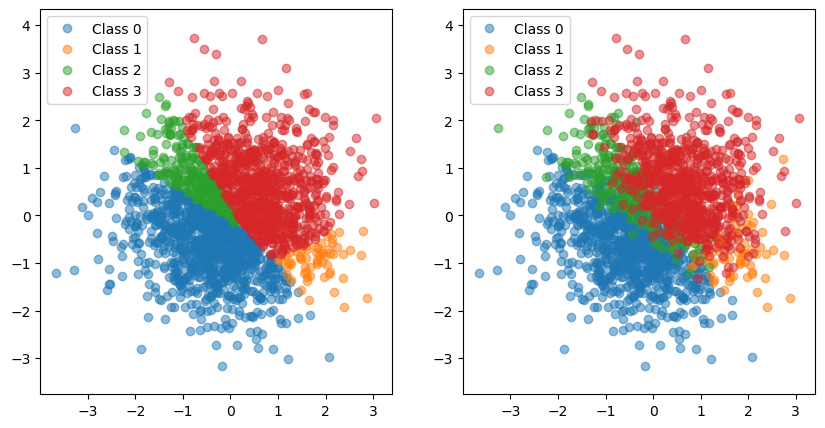

In [73]:
import matplotlib.pyplot as plt

# Plot X colored by y_class
plt.figure(figsize=(5,5))

# Write plot_points function
def plot_points(y, X):
    """Plot points X colored by y."""
    # Get unique classes
    classes = torch.unique(y)
    # Plot each class
    for c in classes:
        # Get indices of points with class c
        idx = y == c
        # Plot points with class c
        plt.plot(X[idx, 0], X[idx, 1], 'o', label=f'Class {c}', alpha=0.5)
    plt.legend()
    plt.axis('equal')

# Create a figure with 2 subplots
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plot_points(y_class, X)
plt.subplot(1, 2, 2)
plot_points(y, X)


In [74]:
X.shape, y.shape

(torch.Size([2000, 2]), torch.Size([2000]))

In [75]:
model = SoftmaxRegression(2, 4)

optim = torch.optim.SGD(model.parameters(), lr=0.2, momentum=0.)

def my_loss(model):
    """Compute the loss of model on y."""
    # Compute the probability of each class
    prob = model(X)
    # Compute the log probability of the correct class
    log_prob = torch.log(prob[range(n_train), y]) # prob[i, y[i]]
    # Compute the normalized negative log likelihood
    loss = -torch.mean(log_prob)
    return loss


In [76]:
# Verify that torch SGD is doing what we expect

# Compute the loss of model on y
loss = my_loss(model)
print(loss)

print("--- Gradient of model parameters before backward pass:")
for name, param in model.named_parameters():
    print(name, ':\n  ', param.grad)

loss.backward()

print("--- Gradient of model parameters after backward pass")
for name, param in model.named_parameters():
    print(name, ':\n  ', param.grad)

tensor(2.1520, grad_fn=<NegBackward0>)
--- Gradient of model parameters before backward pass:
linear.weight :
   None
linear.bias :
   None
--- Gradient of model parameters after backward pass
linear.weight :
   tensor([[ 0.2592,  0.4057],
        [-0.1212,  0.0324],
        [ 0.1785, -0.1345],
        [-0.3165, -0.3036]])
linear.bias :
   tensor([-0.2837,  0.1062,  0.3360, -0.1585])


In [77]:
print("--- Our own gradient step")
print(model.linear.weight - 0.2*model.linear.weight.grad)
print(model.linear.bias - 0.2*model.linear.bias.grad)

# Take a gradient step
optim.step()

print("--- Torch's gradient step")
print(model.linear.weight)
print(model.linear.bias)

--- Our own gradient step
tensor([[-0.1004,  0.5031],
        [-0.3841, -0.0663],
        [ 0.1228, -0.1680],
        [-0.4173, -0.3265]], grad_fn=<SubBackward0>)
tensor([-0.5039, -0.5374,  0.5801, -0.2893], grad_fn=<SubBackward0>)
--- Torch's gradient step
Parameter containing:
tensor([[-0.1004,  0.5031],
        [-0.3841, -0.0663],
        [ 0.1228, -0.1680],
        [-0.4173, -0.3265]], requires_grad=True)
Parameter containing:
tensor([-0.5039, -0.5374,  0.5801, -0.2893], requires_grad=True)


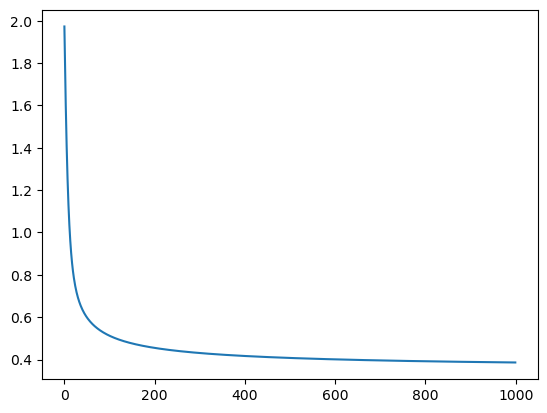

In [79]:
model = SoftmaxRegression(2, 4) # Initialize model

optim = torch.optim.SGD(model.parameters(), lr=.2, momentum=0.)

n_steps = 1000

# Run gradient descent
loss_hist = []
for iter in range(n_steps):
    # Compute the loss
    loss = my_loss(model)
    # Compute the gradient of the loss
    loss.backward()
    # Update the parameters
    optim.step()
    # Set the gradient to zero
    optim.zero_grad()
    # Save the loss
    loss_hist.append(loss.item())

plt.plot(loss_hist)

In [80]:
# compare with true model
print(true_model.linear.weight)
print(model.linear.weight)

Parameter containing:
tensor([[-5.1094, -4.7872],
        [ 5.6040,  2.6706],
        [-0.9777,  1.7367],
        [ 4.5193,  5.0368]], requires_grad=True)
Parameter containing:
tensor([[-3.8162, -3.3184],
        [ 2.2286,  0.3446],
        [-1.3547,  1.1208],
        [ 1.8970,  2.9923]], requires_grad=True)


In [81]:
# compute the accuracy of the model
prob = model(X)
y_class = torch.argmax(prob, dim=1)
print(torch.mean((y_class == y).float()))

# compute Bayes accuracy
prob = true_model(X)
y_class = torch.argmax(prob, dim=1)
print(torch.mean((y_class == y).float()))

tensor(0.8505)
tensor(0.8480)


In [22]:
list(model.parameters()), list(true_model.parameters())

([Parameter containing:
  tensor([[-0.7495, -0.4018],
          [ 0.3192,  0.3215],
          [-0.3730,  0.1327],
          [ 0.1185,  0.5230]], requires_grad=True),
  Parameter containing:
  tensor([-0.0786, -0.5264, -0.0652, -0.1959], requires_grad=True)],
 [Parameter containing:
  tensor([[-0.5109, -0.4787],
          [ 0.5604,  0.2671],
          [-0.0978,  0.1737],
          [ 0.4519,  0.5037]], requires_grad=True),
  Parameter containing:
  tensor([-0.2988, -0.6194, -0.2270, -0.3060], requires_grad=True)])

In [46]:
model.linear.weight.data - true_model.linear.weight.data

tensor([[ 0.5194,  1.0240],
        [-0.3848, -0.8672],
        [ 0.5208,  0.4201],
        [-1.0336, -0.2338]])

In [92]:
def rough_loss(model, batch_size=100):
    """Compute the loss of model on y."""
    # Randomly sample rows of X and y
    idx = torch.randint(0, n_train, (batch_size,))
    Xs, ys = X[idx], y[idx]
    # Compute the probability of each class
    prob = model(Xs)
    # Compute the log probability of the correct class
    log_prob = torch.log(prob[range(batch_size), ys])
    # Compute the normalized negative log likelihood
    loss = -torch.mean(log_prob)
    return loss

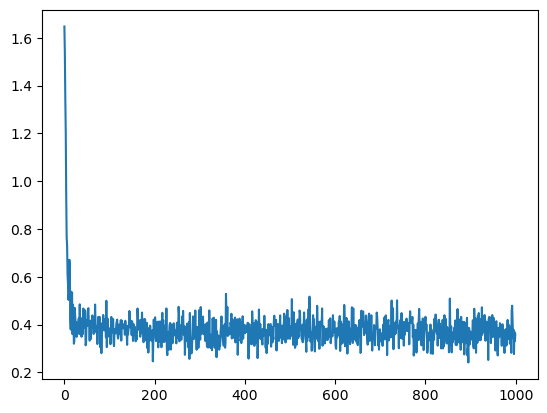

In [93]:
model = SoftmaxRegression(2, 4) # Initialize model

optim = torch.optim.SGD(model.parameters(), lr=.2, momentum=0.9)

n_steps = 1000

# Run gradient descent
loss_hist = []
for iter in range(n_steps):
    # Compute the loss
    loss = rough_loss(model, 200)
    # Compute the gradient of the loss
    loss.backward()
    # Update the parameters
    optim.step()
    # Set the gradient to zero
    optim.zero_grad()
    # Save the loss
    loss_hist.append(loss.item())

plt.plot(loss_hist)